In [9]:
!pip install torch==1.12.1+cu102 torchvision==0.13.1+cu102 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu102
!pip install numpy==1.23.3 pandas triton matplotlib

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu102
     |████████████████████████████████| 8.3 MB 23.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.8 MB 85.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 103.1 MB/s eta 0:00:01
     |████████████████████████████████| 321 kB 109.2 MB/s eta 0:00:01


In [5]:
import torch
import triton
import triton.language as tl
import triton.testing

In [6]:
# 逐块求结果矩阵(分组)
@triton.autotune(
    configs=[
        # 针对小方阵的配置 (256-512)
        triton.Config({'BLOCK_SIZE_M':64,'BLOCK_SIZE_N':64,'BLOCK_SIZE_K':32,'GROUP_SIZE_M':8},num_stages=3,num_warps=4),
        triton.Config({'BLOCK_SIZE_M':64,'BLOCK_SIZE_N':64,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=4),
        triton.Config({'BLOCK_SIZE_M':128,'BLOCK_SIZE_N':128,'BLOCK_SIZE_K':32,'GROUP_SIZE_M':8},num_stages=3,num_warps=4),
        triton.Config({'BLOCK_SIZE_M':128,'BLOCK_SIZE_N':128,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=8),
        
        # 针对中等方阵的配置 (512-1024)
        triton.Config({'BLOCK_SIZE_M':128,'BLOCK_SIZE_N':128,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=4,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':128,'BLOCK_SIZE_N':128,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=4,num_warps=16),
        
        # 针对大方阵的配置 (1024-2048)
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=5,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=4,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=3,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=4,num_warps=16),
        
        # 针对超大方阵的配置 (2048-4096)
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=4,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':256,'GROUP_SIZE_M':8},num_stages=3,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':1024,'BLOCK_SIZE_N':1024,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=32),
        triton.Config({'BLOCK_SIZE_M':1024,'BLOCK_SIZE_N':1024,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=3,num_warps=32),
        
        # 非对称配置，针对某些特定尺寸的优化
        triton.Config({'BLOCK_SIZE_M':128,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':128,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=16),
        
        # 不同阶段数的配置
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=2,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=4,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=5,num_warps=8),
        
        # 不同warp数的配置
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=4),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=32),
        
        # 不同GROUP_SIZE_M值的配置
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':1},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':4},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':16},num_stages=3,num_warps=8),
        
        # 针对特定尺寸的专门优化
        triton.Config({'BLOCK_SIZE_M':128,'BLOCK_SIZE_N':128,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=3,num_warps=4),  # 256-512
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=4,num_warps=8),  # 512-1024
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=4,num_warps=16), # 1024-2048
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=4,num_warps=16), # 2048-4096
        
        # 更多的组合
        triton.Config({'BLOCK_SIZE_M':64,'BLOCK_SIZE_N':64,'BLOCK_SIZE_K':32,'GROUP_SIZE_M':8},num_stages=4,num_warps=4),
        triton.Config({'BLOCK_SIZE_M':128,'BLOCK_SIZE_N':128,'BLOCK_SIZE_K':32,'GROUP_SIZE_M':8},num_stages=4,num_warps=4),
        triton.Config({'BLOCK_SIZE_M':128,'BLOCK_SIZE_N':128,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=4,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':32,'GROUP_SIZE_M':8},num_stages=4,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=4,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':32,'GROUP_SIZE_M':8},num_stages=4,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=5,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=5,num_warps=16),
        
        # 针对大K值的配置
        triton.Config({'BLOCK_SIZE_M':128,'BLOCK_SIZE_N':128,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=3,num_warps=8),
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=3,num_warps=16),
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':256,'GROUP_SIZE_M':8},num_stages=3,num_warps=16),
        
        # 针对不同GPU架构的优化
        triton.Config({'BLOCK_SIZE_M':64,'BLOCK_SIZE_N':64,'BLOCK_SIZE_K':32,'GROUP_SIZE_M':8},num_stages=5,num_warps=2),  # 针对低端GPU
        triton.Config({'BLOCK_SIZE_M':256,'BLOCK_SIZE_N':256,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=4,num_warps=8),  # 针对中端GPU
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=4,num_warps=16),  # 针对高端GPU
        
        # 极端配置，用于探索性能边界
        triton.Config({'BLOCK_SIZE_M':1024,'BLOCK_SIZE_N':1024,'BLOCK_SIZE_K':64,'GROUP_SIZE_M':8},num_stages=2,num_warps=32),
        triton.Config({'BLOCK_SIZE_M':1024,'BLOCK_SIZE_N':1024,'BLOCK_SIZE_K':128,'GROUP_SIZE_M':8},num_stages=2,num_warps=32),
        triton.Config({'BLOCK_SIZE_M':512,'BLOCK_SIZE_N':512,'BLOCK_SIZE_K':256,'GROUP_SIZE_M':8},num_stages=2,num_warps=32),
    ],
    key=['M','N','K'],
)
@triton.jit
def matmul_kernel(
      a_ptr, b_ptr, c_ptr,
      M, N, K,
      stride_am, stride_ak,
      stride_bk, stride_bn,
      stride_cm, stride_cn,
      BLOCK_SIZE_M:tl.constexpr, BLOCK_SIZE_N:tl.constexpr, BLOCK_SIZE_K:tl.constexpr, GROUP_SIZE_M:tl.constexpr
      ):
  # program <-> one block of matrix c <-> pid_m, pid_n, BLOCK_SIZE_M, BLOCK_SIZE_N
  pid = tl.program_id(axis=0)
  # how many blocks in m and n ?
  num_pid_m = tl.cdiv(M,BLOCK_SIZE_M)
  num_pid_n = tl.cdiv(N,BLOCK_SIZE_N)
  # how many blocks in a group ?
  num_pid_in_group = GROUP_SIZE_M * num_pid_n
  # which group current program exists in ?
  group_id = pid // num_pid_in_group
  # start of the group ?
  first_pid_m = group_id * GROUP_SIZE_M
  # if the number of blocks in m isn't divisible by GROUP_SIZE_M, then the last group has not GROUP_SIZE_M lines
  group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
  # the idx of block in group
  pid_in_group = pid % num_pid_in_group
  # pid_m
  pid_m = first_pid_m + pid_in_group % group_size_m
  # pid_n
  pid_n = pid_in_group // group_size_m

  tl.assume(pid_m>=0)
  tl.assume(pid_n>=0)
  tl.assume(stride_am>0)
  tl.assume(stride_ak>0)
  tl.assume(stride_bk>0)
  tl.assume(stride_bn>0)
  tl.assume(stride_cm>0)
  tl.assume(stride_cn>0)

  # element in block
  offs_am = (pid_m*BLOCK_SIZE_M + tl.arange(0,BLOCK_SIZE_M))%M
  offs_bn = (pid_n*BLOCK_SIZE_N + tl.arange(0,BLOCK_SIZE_N))%N
  offs_k = tl.arange(0,BLOCK_SIZE_K)
  a_ptrs = a_ptr + (offs_am[:,None]*stride_am + offs_k[None,:]*stride_ak)
  b_ptrs = b_ptr + (offs_k[:,None]*stride_bk + offs_bn[None,:]*stride_bn)

  # do the multiply
  accumulator = tl.zeros((BLOCK_SIZE_M,BLOCK_SIZE_N),dtype=tl.float32)
  for k in range(0,tl.cdiv(K,BLOCK_SIZE_K)):
    a=tl.load(a_ptrs, mask=offs_k[None,:]<K-k*BLOCK_SIZE_K,other=0.0)
    b=tl.load(b_ptrs, mask=offs_k[:,None]<K-k*BLOCK_SIZE_K,other=0.0)
    accumulator = tl.dot(a,b, accumulator)
    a_ptrs+=BLOCK_SIZE_K*stride_ak
    b_ptrs+=BLOCK_SIZE_K*stride_bk
  c = accumulator.to(tl.float16)

  # write the result in c
  offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0,BLOCK_SIZE_M)
  offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0,BLOCK_SIZE_N)
  c_ptrs = c_ptr+stride_cm*offs_cm[:,None] + stride_cn * offs_cn[None,:]
  c_mask =(offs_cm[:,None]<M)&(offs_cn[None,:]<N)
  tl.store(c_ptrs, c, mask=c_mask)

def matmul(a, b):
  assert a.shape[1] == b.shape[0], "Incompatible dimensions"
  assert a.is_contiguous(), "Matrix A bust be contiguous"
  M, K = a.shape
  K, N = b.shape
  c = torch.empty((M,N),device=a.device, dtype=torch.float16)
  grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M'])*triton.cdiv(N, META['BLOCK_SIZE_N']),)
  matmul_kernel[grid](a,b,c,M,N,K,a.stride(0),a.stride(1),b.stride(0),b.stride(1),c.stride(0),c.stride(1))
  return c

In [7]:
DEVICE = "cuda"
torch.manual_seed(0)
a = torch.rand((512, 512), device=DEVICE, dtype=torch.float16) - 0.5
b = torch.rand((512, 512), device=DEVICE, dtype=torch.float16) - 0.5
triton_output = matmul(a, b)
torch_output = torch.matmul(a, b)
print(f"triton_output_with_fp16_inputs={triton_output}")
print(f"torch_output_with_fp16_inputs={torch_output}")

if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=0):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

triton_output_with_fp16_inputs=tensor([[-0.5210,  2.8730, -1.0684,  ..., -0.7812,  0.8306,  0.5127],
        [ 2.3477, -1.5615,  1.9453,  ..., -0.1976, -1.5498, -2.5508],
        [ 0.3354, -1.3828,  2.9043,  ..., -1.2051, -1.5752,  3.5742],
        ...,
        [ 2.0586,  1.3125, -4.1484,  ..., -2.1113,  0.9893, -1.0977],
        [-0.3135, -2.9375, -1.8770,  ...,  1.3574, -1.6885,  3.9180],
        [ 0.3804, -0.9829,  0.4966,  ...,  1.8525,  0.3730,  2.6895]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[-0.5205,  2.8730, -1.0684,  ..., -0.7812,  0.8306,  0.5127],
        [ 2.3477, -1.5615,  1.9453,  ..., -0.1978, -1.5488, -2.5508],
        [ 0.3364, -1.3828,  2.9043,  ..., -1.2051, -1.5752,  3.5742],
        ...,
        [ 2.0586,  1.3125, -4.1484,  ..., -2.1113,  0.9888, -1.0977],
        [-0.3135, -2.9375, -1.8770,  ...,  1.3574, -1.6885,  3.9199],
        [ 0.3804, -0.9829,  0.4968,  ...,  1.8525,  0.3728,  2.6895]],
       device='cuda:0', dt

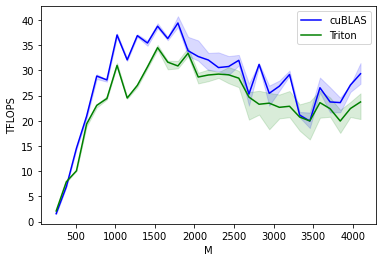

matmul-performance-fp16:
         M       N       K     cuBLAS     Triton
0    256.0   256.0   256.0   1.579181   2.114065
1    384.0   384.0   384.0   6.912000   7.899428
2    512.0   512.0   512.0  14.563555  10.082462
3    640.0   640.0   640.0  20.897960  19.366431
4    768.0   768.0   768.0  28.859889  23.055009
5    896.0   896.0   896.0  28.098561  24.407000
6   1024.0  1024.0  1024.0  37.005164  30.975707
7   1152.0  1152.0  1152.0  32.069636  24.503524
8   1280.0  1280.0  1280.0  36.869760  27.011232
9   1408.0  1408.0  1408.0  35.411922  30.671032
10  1536.0  1536.0  1536.0  38.743145  34.489478
11  1664.0  1664.0  1664.0  36.290510  31.616733
12  1792.0  1792.0  1792.0  39.376129  30.864291
13  1920.0  1920.0  1920.0  33.882354  33.391304
14  2048.0  2048.0  2048.0  32.736031  28.671343
15  2176.0  2176.0  2176.0  32.039244  29.071225
16  2304.0  2304.0  2304.0  30.543490  29.249710
17  2432.0  2432.0  2432.0  30.754751  29.109664
18  2560.0  2560.0  2560.0  31.978529  28.44

In [10]:
DEVICE = 'cuda'

ref_lib = 'cuBLAS'

configs = [
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],
        x_vals=[128 * i for i in range(2, 33)],  # 从 256 到 4096
        line_arg="provider",
        line_vals=[ref_lib.lower(), "triton"],
        line_names=[ref_lib, "Triton"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="TFLOPS",
        plot_name="matmul-performance-fp16",
        args={},
    )
]

@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)

    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)

    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=True, print_data=True)